In [1]:
from youtube_search import YoutubeSearch
import pandas as pd
import numpy as np
import main

In [3]:
tracks = pd.read_csv('tracks.csv')
tracks.head()

,genre,band_name,album_name,album_id,track_title,track_id,preview_downloaded
0,thrash metal,Metallica,72 Seasons,6UwjRSX9RQyNgJ3LwYhr9i,72 Seasons,3uSATa7xWXVJrMhJJSnGGk,N
1,thrash metal,Metallica,72 Seasons,6UwjRSX9RQyNgJ3LwYhr9i,Shadows Follow,5iG1GycXpheJ5xMW0gNvKv,N
2,thrash metal,Metallica,72 Seasons,6UwjRSX9RQyNgJ3LwYhr9i,Screaming Suicide,2hBn08QphNtdnhwDNtnZMg,N
3,thrash metal,Metallica,72 Seasons,6UwjRSX9RQyNgJ3LwYhr9i,Sleepwalk My Life Away,6HeYgpgqEo8SGis4dHwRbu,N
4,thrash metal,Metallica,72 Seasons,6UwjRSX9RQyNgJ3LwYhr9i,You Must Burn!,1ALXFmNr7lrTug2LAE989q,N


In [11]:
genre_counts = tracks['genre'].value_counts()

popular_genres = genre_counts[genre_counts > 10000].index.tolist()

tracks10k = tracks[tracks['genre'].isin(popular_genres)]


sampled_tracks = {}

# Group by genre
grouped = tracks10k.groupby('genre')

# Iterate over each genre
for genre, group_data in grouped:
    # Select 100 random rows for each genre
    sampled_tracks[genre] = group_data.sample(n=100, replace=False, random_state=42)

# Concatenate the sampled rows for all genres
sampled_tracks_df = pd.concat(sampled_tracks.values())
c=0
for index, row in sampled_tracks_df.iterrows():
    # Perform YouTube search based on track title and band name
    search_query = row['track_title'] + ' ' + row['band_name']
    search_result = YoutubeSearch(search_query, max_results=1).to_dict()
    
    # Extract the 'url_suffix' from the search result
    url_suffix = search_result[0]['url_suffix'] if search_result else None
    if url_suffix is not None:
        c += 1
        if c % 100 == 0:
            print(f'{c} of {sampled_tracks_df.shape[0]} tracks processed')
    # Assign the url_suffix value to the 'youtube_url' column
    sampled_tracks_df.at[index, 'youtube_url'] = url_suffix
print('all tracks processed')
sampled_tracks_df.to_csv('sampled_tracks.csv', index=False)

100 of 1200 tracks processed
200 of 1200 tracks processed
300 of 1200 tracks processed
400 of 1200 tracks processed
500 of 1200 tracks processed
600 of 1200 tracks processed
700 of 1200 tracks processed
800 of 1200 tracks processed
900 of 1200 tracks processed
1000 of 1200 tracks processed
1100 of 1200 tracks processed
all tracks processed


In [8]:
with open('validation.csv', 'w', newline='', encoding='utf-8') as f:
    f.write('genre|band_name|album_name|album_id|track_title|track_id|preview_downloaded|youtube_url|prediction\n')
    

In [4]:
import pandas as pd
import main  # Assuming main.py contains the main function

sampled_tracks_df = pd.read_csv('sampled_tracks.csv')
validation = pd.read_csv('validation.csv', delimiter='|')
validated = set(validation['track_id'])


# Iterate through each row
with open('validation.csv', 'a', newline='', encoding='utf-8') as f:
    for index, row in sampled_tracks_df.iterrows():
        # Skip the row if the track has already been validated
        if row['track_id'] in validated:
            continue
        else:
            youtube_url = 'https://www.youtube.com/' + row['youtube_url']
            prediction = main.main(youtube_url)
            row['prediction'] = prediction
            # Write the row to the CSV file
            f.write('|'.join(map(str, row.values)) + '\n')
            f.flush()
            

In [3]:
validation = pd.read_csv('validation.csv')
validation['success'] = (validation['genre'] == validation['prediction']).astype(int)
validation.groupby('genre')['success'].value_counts()

genre              success
black metal        1          51
                   0          49
death metal        0          57
                   1          43
doom metal         1          50
                   0          48
folk metal         0          51
                   1          48
glam metal         1          68
                   0          31
grindcore          1          78
                   0          20
industrial metal   1          72
                   0          28
metalcore          1          50
                   0          48
nu metal           1          57
                   0          40
power metal        0          53
                   1          47
progressive metal  1          60
                   0          38
thrash metal       0          53
                   1          47
Name: count, dtype: int64

<Axes: xlabel='genre'>

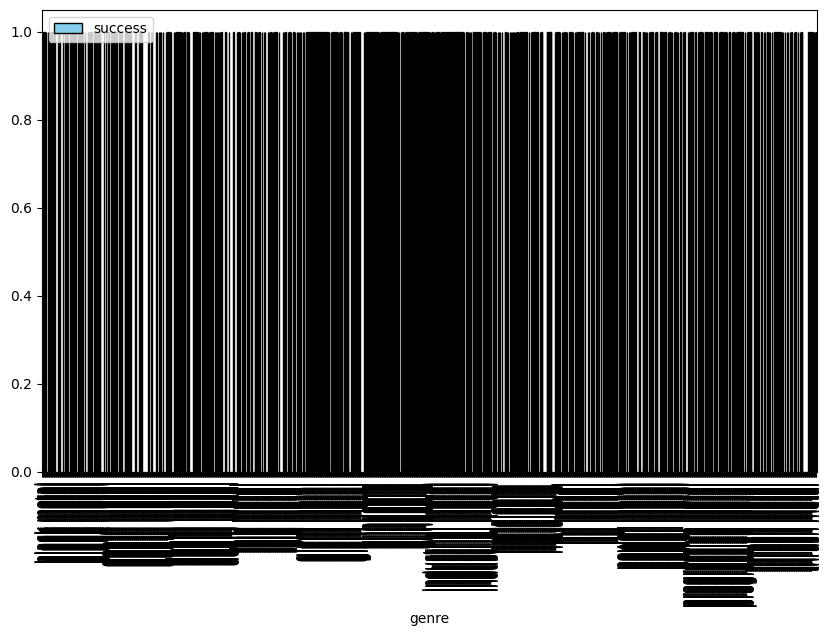

In [5]:
validation_failed = validation[validation['success'] == 0]
validation_failed.to_csv('validation_failed.csv', index=False)
validation.plot(kind='bar', x='genre', y='success', figsize=(10, 6), color='skyblue', edgecolor='black')